In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future warnings for GraphPPL are suppressed.


In [2]:
import PolynomialRoots: roots
using Distributions

function generate_coefficients(order::Int)
    stable = false
    true_a = []
    # Keep generating coefficients until we come across a set of coefficients
    # that correspond to stable poles
    while !stable
        true_a = randn(order)
        coefs =  append!([1.0], -true_a)
        #reverse!(coefs)
        if false in ([abs(root) for root in roots(coefs)] .> 1)
            continue
        else
            stable = true
        end
    end
    return true_a
end

function generateSWAR(num::Int, order::Int; nvar=1, pi=0.5)
    coefs1 = generate_coefficients(order)
    coefs2 = generate_coefficients(order)
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    _pis = []
    for i in 2:num+3*order
        push!(_pis, rand(Distributions.Bernoulli(pi)))
        coefs = _pis[end] == 1 ? coefs1 : coefs2
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar)), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs1, coefs2, _pis, data
end

function time_varying_variance(kappa, omega, vtop,n_samples)
    x1, x2 = Array{Float64}(undef,n_samples+1), Array{Float64}(undef,n_samples)
    x1[1] = randn()
    for i=1:n_samples
        x1[i+1] = x1[i] + sqrt(vtop)*randn()
        x2[i] = exp(kappa*x1[i+1] +omega)
    end
    return x1, x2
end


function generateHGFAR(num::Int, order::Int, kappa, omega, vtop)
    coefs = generate_coefficients(order)
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    rw, tvar = time_varying_variance(kappa, omega, vtop, num+3*order)
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(tvar[i])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data, tvar[1+3*order:end], rw[1+3*order:end]
end

function generateAR(num::Int, order::Int; nvar=1, stat=true, coefs=nothing)
    if isnothing(coefs) && stat
        coefs = generate_coefficients(order)
    else
        coefs = randn(order)
    end
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(nvar[])), 1)[1])
    end
    data = data[1+3*order:end]
    return coefs, data
end

function generateHAR(num::Int, order::Int; levels=2, nvars=[], stat=true)
    # generate first layer
    if isempty(nvars)
        nvars = ones(levels)
    elseif length(nvars) != levels
        throw(DimensionMismatch("size of variances is not equal to number of levels"))
    end
    θ1, θ2 = generateAR(num, order; nvar=nvars[1], stat=stat)
    data = [θ1, θ2]
    for level in 2:levels
        states = Vector{Vector{Float64}}(undef, num)
        states[1] = randn(order)
        for i in 2:num
            states[i] = insert!(states[i-1][1:end-1], 1, rand(Distributions.Normal(data[level][i]'states[i-1], sqrt(nvars[2])), 1)[1])
        end
        push!(data, states)
    end
    return data
end

function generateSIN(num::Int, noise_variance=1/5)
    coefs = [2cos(1), -1]
    order = length(coefs)
    inits = [sin(1), sin(0)]
    data = Vector{Vector{Float64}}(undef, num+10*order)
    data[1] = inits
    for i in 2:num+10*order
        data[i] = insert!(data[i-1][1:end-1], 1, coefs'data[i-1])
        data[i][1] += sqrt(noise_variance)*randn()
    end
    data = data[1+10*order:end]
    return coefs, data
end

generateSIN (generic function with 2 methods)

In [88]:
@model function lar_model_multivariate(n, order, c, stype)
    x = randomvar(n)
    y = datavar(Float64, n)
    
    γ  ~ GammaShapeRate(1.0, 1.0) where { q = MeanField() }
    θ  ~ MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)) where { q = MeanField() }
    x0 ~ MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)) where { q = MeanField() }
    
    ct  = constvar(c)
    γ_y = constvar(1.0)
    
    x_prev = x0
    
    ar_nodes = Vector{FactorNode}(undef, n)
    
    meta = ARMeta(Multivariate, order, stype)
    
    for i in 1:n
        ar_nodes[i], x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), γ_y) where { q = MeanField() }
        x_prev = x[i]
    end
    
    return x, y, θ, γ, ar_nodes
end

lar_model_multivariate (generic function with 2 methods)

In [89]:
@model function lar_model_univariate(n, order, c, stype)
    x = randomvar(n)
    y = datavar(Float64, n)
    
    γ  ~ GammaShapeRate(1.0, 1.0) where { q = MeanField() }
    θ  ~ NormalMeanPrecision(0.0, 1.0) where { q = MeanField() }
    x0 ~ NormalMeanPrecision(0.0, 1.0) where { q = MeanField() }
    
    γ_y = constvar(1.0)
    
    x_prev = x0
    
    ar_nodes = Vector{FactorNode}(undef, n)
    
    meta = ARMeta(Univariate, order, stype)
    
    for i in 1:n
        ar_nodes[i], x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(x[i], γ_y) where { q = MeanField() }
        x_prev = x[i]
    end
    
    return x, y, θ, γ, ar_nodes
end

lar_model_univariate (generic function with 2 methods)

In [90]:
lar_model(::Type{ Multivariate }, n, order, c, stype) = lar_model_multivariate(n, order, c, stype)
lar_model(::Type{ Univariate }, n, order, c, stype)   = lar_model_univariate(n, order, c, stype)

lar_model (generic function with 5 methods)

In [91]:
function init_marginals(::Type{ Multivariate }, order, ar_nodes, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)))
    
    for i in 1:length(ar_nodes)
        setmarginal!(ar_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2order), Matrix{Float64}(I, 2order, 2order)))
    end
end

function init_marginals(::Type{ Univariate }, order, ar_nodes, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
    
    for i in 1:length(ar_nodes)
        setmarginal!(ar_nodes[i], :y_x, MvNormalMeanPrecision(zeros(2), Matrix{Float64}(I, 2, 2)))
    end
end

init_marginals (generic function with 2 methods)

In [107]:
function inference(data, order, artype, stype, niter)
    n = length(data)
    
    c = ReactiveMP.ar_unit(artype, order)
    
    model, (x, y, θ, γ, ar_nodes) = lar_model(artype, n, order, c, stype)
    
    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    
    fe = Vector{Float64}()
    
    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(collectLatest(getmarginals(x)), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))
    
    init_marginals(artype, order, ar_nodes, γ, θ)
    
    ProgressMeter.@showprogress for i in 1:niter
        update!(y, data)
    end
    
    unsubscribe!(γsub)
    unsubscribe!(θsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)
    
    return γ_buffer, θ_buffer, x_buffer, fe
end

inference (generic function with 2 methods)

In [108]:
using Random

Random.seed!(42)
n = 100
ar_order = 5
coefs, data = generateAR(n, ar_order)
hidden_states =  first.(data)
observations = hidden_states .+ randn(length(hidden_states));
# γ, θ, xs, fe = inference(observations, 1, 100)


In [118]:
γ, θ, xs, fe = inference(observations, 5, Multivariate, ARsafe(), 100);
mx, vx = mean.(xs), cov.(xs)
mx = first.(mx)
vx = first.(vx)
mθ = mean(θ)
vθ = cov(θ)
mγ = mean(γ)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


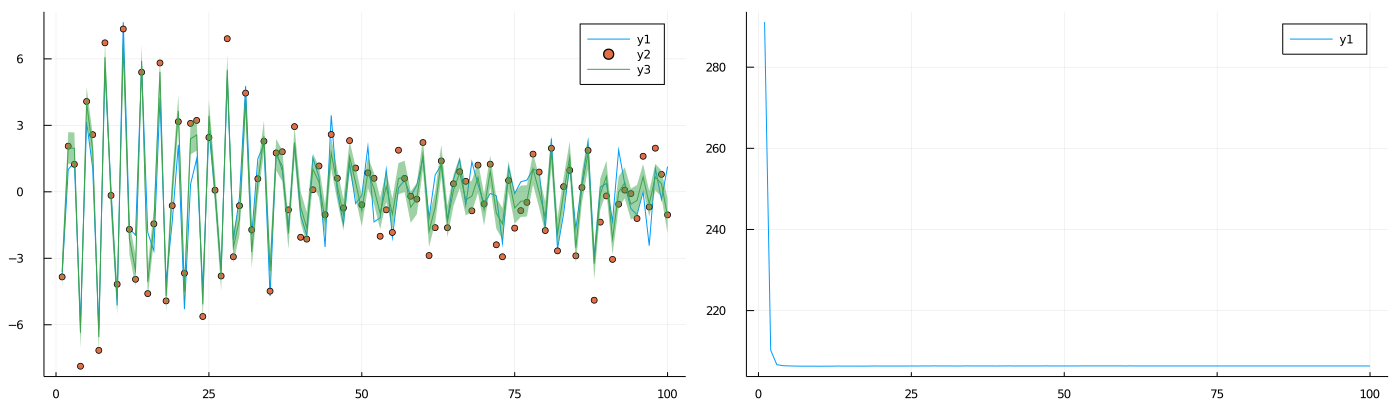

In [119]:
using Plots
p1 = plot(hidden_states)
p1 = scatter!(p1, observations)
p1 = plot!(p1, mx, ribbon = sqrt.(vx))

p2 = plot(fe)

plot(p1, p2, size = (1400, 400))

In [ ]:
x